In [194]:
import re
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from wordcloud import WordCloud


plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

from env import *
from acquire import *
from prepare import *

## 1. Spam Data

### a. Load the spam data set

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [197]:
class NLP_explore():
    '''Explores some plots and other features and frequencies, bigrams of 
    two selected comparisons within a dataframe based on a specific label
    '''
    def __init__(self, df, label_col, text_col, c1, c2):
        '''Pass df, label_col (what is the category), text_col is
        where the text is located, and c1 & c2 are the comparison strings
        '''
        # Create all class attributes
        self.df = df
        self.label_col = label_col
        self.text_col = text_col
        self.c1 = c1
        self.c2 = c2
        comp1 = df[df[label_col] == c1][text_col]
        comp2 = df[df[label_col] == c2][text_col]
        # Joined text from comparison 1
        self.text1 = comp1.str.cat(sep=' ')
        # Joined text from comparison 2
        self.text2 = comp2.str.cat(sep=' ')

        # Clean words for text 1
        self.w1 = basic_clean(self.text1)
        # Clean words for text 2
        self.w2 = basic_clean(self.text2)
        # All cleaned words combined
        self.all_words = f'{self.w1} {self.w2}'        
        
        # Calculates cond1 frequencies
        self.cond1_freq = pd.Series(self.w1.split()).value_counts()
        # Calculates cond2 frequencies
        self.cond2_freq = pd.Series(self.w2.split()).value_counts()
        # Calculates all word frequencies
        self.all_freq = pd.Series(self.all_words.split()).value_counts()
        
        # Creates attribute of word_counts to view the word counts
        # for the condition
        word_counts = pd.concat(
            [self.cond1_freq,
             self.cond2_freq,
             self.all_freq],
            axis=1).fillna(0).astype(int)
        word_counts.columns=[c1, c2, 'all']
        self.word_counts = word_counts
        
        # Name columns
        
        
    # Create method to plot a horizontal plot for the frequencies
    def hplot_word_freq_viz(self, n=20, sort='all', asc=False):
        '''Takes n which is the number of top values you'd like to plot
        and a sort col, default is 'all', ascending defaults to False
        '''
        plt.rc('font', size=18)
        self.word_counts.\
            sort_values(sort, ascending=asc
                       ).head(n)[[self.c1, self.c2]].plot.barh()
        plt.title(f'''{self.c1.capitalize()} vs {self.c2.capitalize()} count for the top {n} most frequent words''')
        plt.xlabel('Count')
        plt.show()
        
    # Create method to stacked barplot for word counts
    def stacked_bplot_freq(self, n=20, sort='all', asc=False):
        '''Takes n which is the number of top values you'd like to plot
        and a sort col, default is 'all', ascending defaults to False
        plots a stacked barchart plot
        '''
        plt.figure(figsize=(16, 9))
        plt.rc('font', size=16)

        (self.word_counts.sort_values(sort, ascending=asc)
         .head(n)
         .apply(lambda row: row/row['all'], axis = 1)
         .drop(columns = 'all')
         .sort_values(by = self.c1)
         .plot.barh(stacked = True, width = 1, ec = 'k')
        )
        plt.title(f'''% of {self.c1.capitalize()} vs {self.c2.capitalize()} count for the top {n} most frequent words''')
        plt.xlabel('Percentage')
        plt.show()
    
    # Create method to plot a horizontal plot for the bigrams
    def bigram(self, col='all', n=20, asc=False):
        '''Takes n which is the number of top values you'd like to pull from the 
        bigram and then you plot those pairs on a horizontal plot 
        default is 'all', ascending defaults to False
        '''
        # generates bigrams which are combinations of two words 
        # throughout the string
        
        # Condition 1 bigrams
        if col == self.c1:
            bigrams = list(nltk.bigrams(self.w1.split()))
        # Condition 2 bigrams
        elif col == self.c2:
            bigrams = list(nltk.bigrams(self.w2.split()))
        # If all or not in the conditions go to all
        else:
            bigrams = list(nltk.bigrams(self.all_words.split()))
            
        
        # Plot the bigrams
        pd.Series(bigrams).value_counts().head(n).plot.barh()
        # Set the title
        plt.title(f'Top {n} most common {col.capitalize()} bigrams')
        # Label the x axis with count
        plt.xlabel('Count')
        # Show plot
        plt.show()
        
        # Return the bigram for that selected column
        return bigrams
    
    # Create wordcloud plot based on condition
    def plot_wordcloud(self, col='all', kwargs=None)
    '''Allows for wordcloud to be plotted '''
    

        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        

In [190]:
# Ham & Spam compairson
hns = NLP_explore(df, 'label', 'text', 'ham', 'spam')

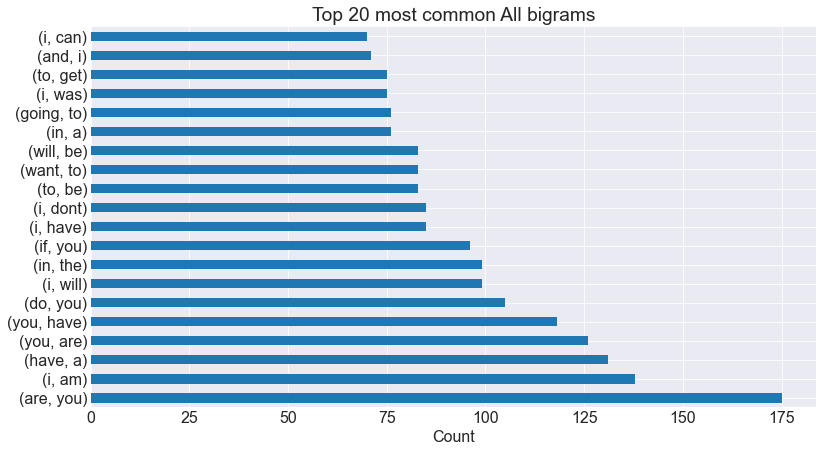

In [192]:
all_bigrams = hns.bigram()

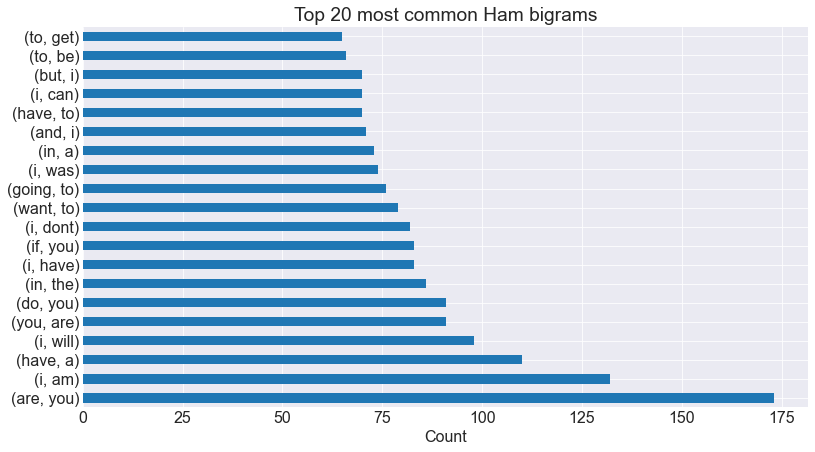

In [196]:
spam_bigram = hns.bigram('spam')

<Figure size 1152x648 with 0 Axes>

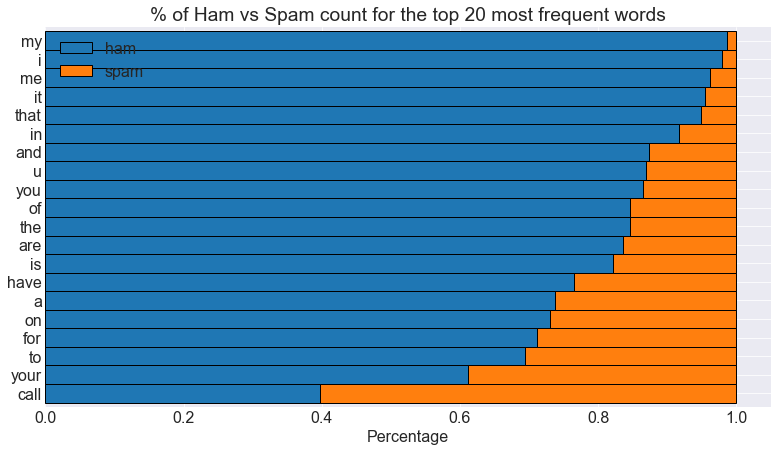

In [179]:
hns.stacked_bplot_freq()

### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [ ]:
# combine all messages in single string by label

ham_words = build_word_count_df(df[df.label == 'ham'])
spam_words = basic_clean(' '.join(df[df.label == 'spam'].text))
all_words = basic_clean(' '.join(df.text))

In [ ]:
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

spam_freq.head(6)

In [ ]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['ham', 'spam', 'all']
word_counts.head()

### c. Is there any overlap in the bigrams for the spam data and the ham data?

### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the `category` variable when exploring.